### Установка и импорт необходимых пакетов

In [ ]:
from argparse import Namespace
import os
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

---

### Обработка текста

In [ ]:
!wget -O 'surnames_with_splits.csv' -q 'https://www.dropbox.com/s/0cfngajqyyxxfy3/surnames_with_splits.csv?dl=0'

In [ ]:
df = pd.read_csv('surnames_with_splits.csv')
df.head(5)

,surname,nationality,split
0,Totah,Arabic,train
1,Abboud,Arabic,train
2,Fakhoury,Arabic,train
3,Srour,Arabic,train
4,Sayegh,Arabic,train


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10980 entries, 0 to 10979
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   surname      10980 non-null  object
 1   nationality  10980 non-null  object
 2   split        10980 non-null  object
dtypes: object(3)
memory usage: 257.5+ KB


In [ ]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [ ]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [ ]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""   
    def __init__(self, char_vocab, nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            title (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token) 
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)         
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index
        
        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

In [ ]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df 
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = self.train_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))
        
   
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]
        
        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)
        
        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector, 
                'y_target': nationality_index, 
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

---

### Модель

In [ ]:
def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


class SurnameClassifier(nn.Module):
    """ A Classifier with an LSTM to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 lstm_hidden_size, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector 
                Note: the number of nationalities
            lstm_hidden_size (int): The size of the LSTM's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
        """
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.lstm = nn.LSTM(input_size=embedding_size, # сменил RNN на LSTM
                           hidden_size=lstm_hidden_size,
                           batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=lstm_hidden_size,
                         out_features=lstm_hidden_size)
        self.fc2 = nn.Linear(in_features=lstm_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out, _ = self.lstm(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(y_out))
        y_out = self.fc2(y_out)
        # y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        # y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [ ]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

---

## 1-й эксперимент

### Настройка: используются значения гиперпараметров из практической работы, RNN заменена на LSTM

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=100,
    lstm_hidden_size=64,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=64, 
    seed=0,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [ ]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               lstm_hidden_size=args.lstm_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

---

### Тренировка сети

In [ ]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
# loss_func = nn.CrossEntropyLoss(dataset.class_weights)
loss_func = nn.CrossEntropyLoss() # без балансировки классов
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                        batch_size=args.batch_size, 
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
    
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'], 
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/25 [00:00<?, ?it/s]

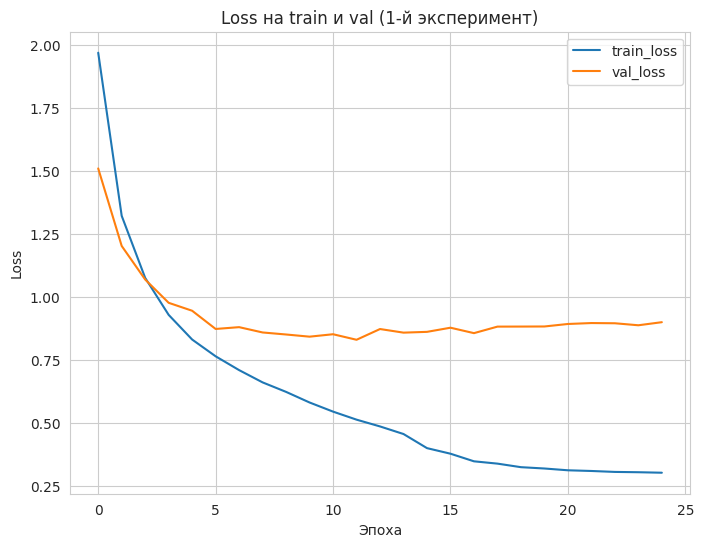

In [ ]:
loss_labels = ["train_loss", "val_loss"]
plt.figure(figsize=(8, 6))
for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Loss на train и val (1-й эксперимент)')
plt.show()

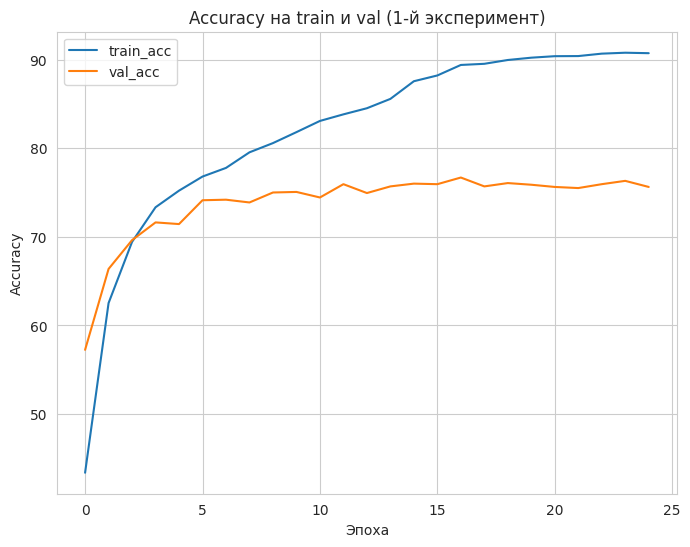

In [ ]:
acc_labels = ["train_acc", "val_acc"]
plt.figure(figsize=(8, 6))
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('Accuracy на train и val (1-й эксперимент)')
plt.show()

---

### Инференс

In [ ]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)
    
    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    
    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return f"{surname} - {predicted_nationality} ({round(prob_value, 2)})"

In [ ]:
# surname = input("Enter a surname: ")
classifier = classifier.to("cpu")
for surname in ['McMahan', 'Nakamoto', 'Wan', 'Cho']:
    print(predict_nationality(surname, classifier, vectorizer))

McMahan - English (0.48)
Nakamoto - Japanese (1.0)
Wan - Chinese (0.83)
Cho - Korean (0.4)


In [ ]:
classifier.eval()

SurnameClassifier(
  (emb): Embedding(80, 100, padding_idx=0)
  (lstm): LSTM(100, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=18, bias=True)
)

---

## 2-й эксперимент

### Настройка: RNN заменена на LSTM, изменены гиперпараметры

embedding_size=100 --> embedding_size=200

lstm_hidden_size=64 --> lstm_hidden_size=128

batch_size=64 --> batch_size=96

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=200,
    lstm_hidden_size=128,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=96,
    seed=0,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [ ]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               lstm_hidden_size=args.lstm_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

---

### Тренировка сети

In [ ]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
# loss_func = nn.CrossEntropyLoss(dataset.class_weights)
loss_func = nn.CrossEntropyLoss() # без балансировки классов
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                        batch_size=args.batch_size, 
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
    
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'], 
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/25 [00:00<?, ?it/s]

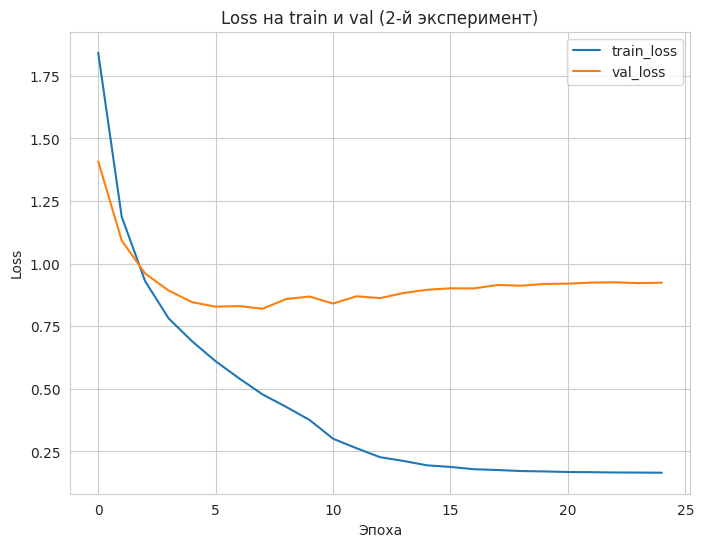

In [ ]:
loss_labels = ["train_loss", "val_loss"]
plt.figure(figsize=(8, 6))
for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Loss на train и val (2-й эксперимент)')
plt.show()

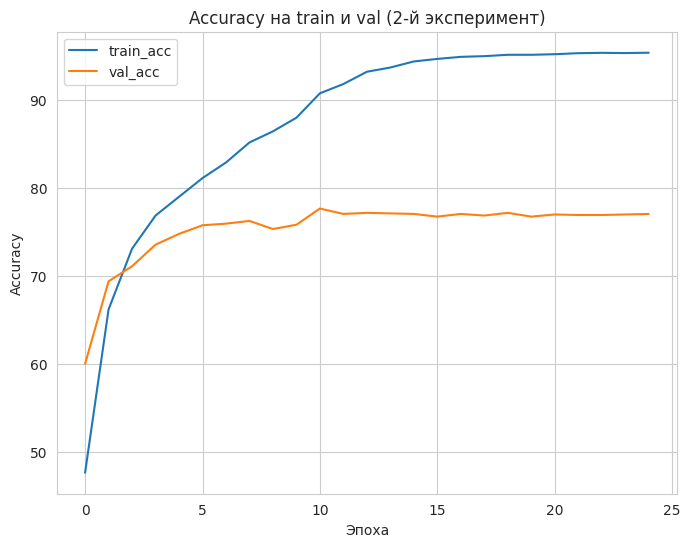

In [ ]:
acc_labels = ["train_acc", "val_acc"]
plt.figure(figsize=(8, 6))
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('Accuracy на train и val (2-й эксперимент)')
plt.show()

---

### Инференс

In [ ]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)
    
    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    
    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return f"{surname} - {predicted_nationality} ({round(prob_value, 2)})"

In [ ]:
# surname = input("Enter a surname: ")
classifier = classifier.to("cpu")
for surname in ['McMahan', 'Nakamoto', 'Wan', 'Cho']:
    print(predict_nationality(surname, classifier, vectorizer))

McMahan - Irish (0.72)
Nakamoto - Japanese (1.0)
Wan - Chinese (0.94)
Cho - Korean (0.79)


In [ ]:
classifier.eval()

SurnameClassifier(
  (emb): Embedding(80, 200, padding_idx=0)
  (lstm): LSTM(200, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=18, bias=True)
)

Видно, что при увеличении значений указанных выше гиперпараметров модель сильнее "подогналась" под обучающие данные. Лосс на валидационном сете немного увеличился, на тренировочном - снизился (по сравнению с предыдущим набором гиперпараметров). Также качество на трейне и на валидационном сете во втором случае улучшилось (на трейне сильнее). При этом LSTM с гиперпараметрами из практической работы значительно улучшил качество классификации по сравнению с RNN.

---

### Зависимость качества классификации от кол-ва эпох

При первом наборе гиперпараметров ошибка на валидационном сете начала расти после 11-й эпохи, при втором наборе - где-то после 10-й эпохи. Accuracy после 10-й эпохи при обоих наборах на валидационном сете улучшилось не сильно или не улучшилось вовсе, при этом на тренировочном - продолжило расти. В целом, можно сказать, что модели с обоими наборами гиперпараметров достаточно около 10-и эпох, далее идет переобучение. При этом во втором случае переобучение идет быстрее (начиная примерно с 10-й эпохи) и лосс на трейне падает стремительнее.

---

### Балансировка классов в лоссе

In [ ]:
df.nationality.value_counts()

English       2972
Russian       2373
Arabic        1603
Japanese       775
Italian        600
German         576
Czech          414
Spanish        258
Dutch          236
French         229
Chinese        220
Irish          183
Greek          156
Polish         120
Korean          77
Scottish        75
Vietnamese      58
Portuguese      55
Name: nationality, dtype: int64

## 1-й эксперимент (с балансировкой)

### Настройка: используются значения гиперпараметров из практической работы, RNN заменена на LSTM

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=100,
    lstm_hidden_size=64,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=64, 
    seed=0,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [ ]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               lstm_hidden_size=args.lstm_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

---

### Тренировка сети

In [ ]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                        batch_size=args.batch_size, 
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
    
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'], 
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/25 [00:00<?, ?it/s]

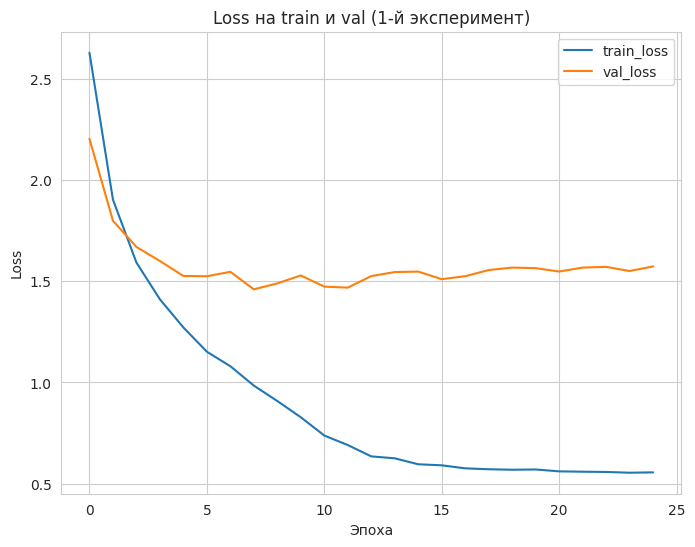

In [ ]:
loss_labels = ["train_loss", "val_loss"]
plt.figure(figsize=(8, 6))
for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Loss на train и val (1-й эксперимент)')
plt.show()

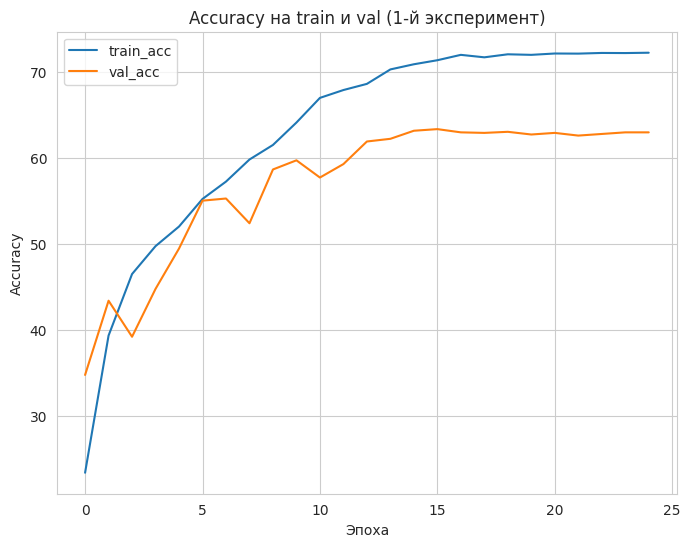

In [ ]:
acc_labels = ["train_acc", "val_acc"]
plt.figure(figsize=(8, 6))
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('Accuracy на train и val (1-й эксперимент)')
plt.show()

---

## 2-й эксперимент (с балансировкой)

### Настройка: RNN заменена на LSTM, изменены гиперпараметры

embedding_size=100 --> embedding_size=200

lstm_hidden_size=64 --> lstm_hidden_size=128

batch_size=64 --> batch_size=96

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=200,
    lstm_hidden_size=128,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=96,
    seed=0,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [ ]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               lstm_hidden_size=args.lstm_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

---

### Тренировка сети

In [ ]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                        batch_size=args.batch_size, 
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
    
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'], 
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/25 [00:00<?, ?it/s]

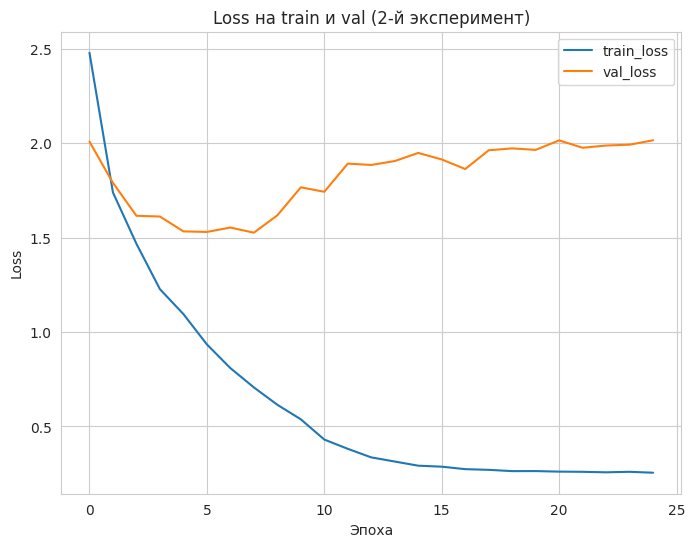

In [ ]:
loss_labels = ["train_loss", "val_loss"]
plt.figure(figsize=(8, 6))
for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Loss на train и val (2-й эксперимент)')
plt.show()

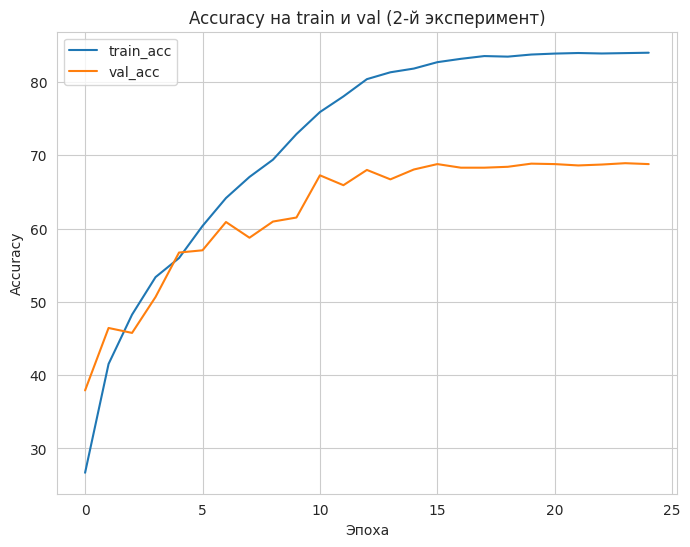

In [ ]:
acc_labels = ["train_acc", "val_acc"]
plt.figure(figsize=(8, 6))
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('Accuracy на train и val (2-й эксперимент)')
plt.show()

При наличии аргумента с весами классов у функции потерь качество классификации ухудшилось, а loss увеличился на обоих наборах гиперпараметров и на обоих датасетах (тренировочном и валидационном). При этом во втором случае наблюдается резкое переобучение после 8  эпохи, но accuracy - выше. Возможно, такие изменения связаны с тем, что модель без взвешивания классов в лоссе обучается хорошо предсказывать мажоритарные классы. Это дает хорошие показатели качества при данной структуре датасета.

---

### Матрица ошибок

### Модель со второй группой гиперпараметров и балансировкой классов в лоссе

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [ ]:
X_test = df[df['split'] == 'val']['surname']
y_test = df[df['split'] == 'val']['nationality']

In [ ]:
def predict_nationality_only(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)
    
    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    
    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return predicted_nationality

In [ ]:
y_pred = []
for surname in X_test:
    y_pred.append(predict_nationality_only(surname, classifier, vectorizer))

In [ ]:
labels = df.nationality.value_counts().index

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=labels)

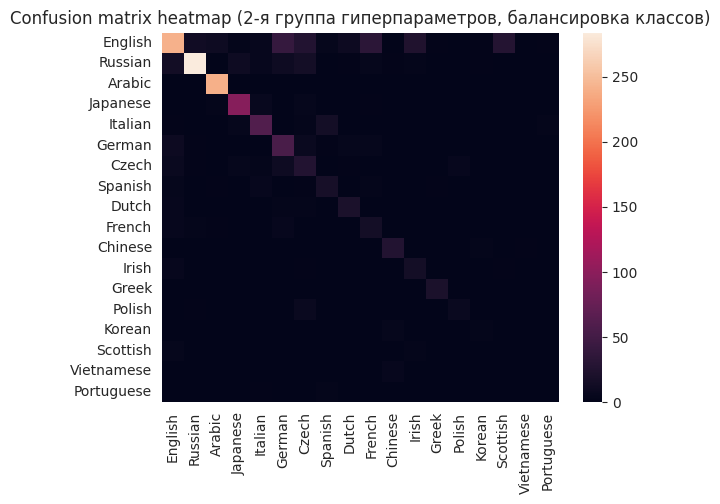

In [ ]:
sns.heatmap(cm, xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix heatmap (2-я группа гиперпараметров, балансировка классов)')
plt.show()

In [ ]:
df.nationality.value_counts()

English       2972
Russian       2373
Arabic        1603
Japanese       775
Italian        600
German         576
Czech          414
Spanish        258
Dutch          236
French         229
Chinese        220
Irish          183
Greek          156
Polish         120
Korean          77
Scottish        75
Vietnamese      58
Portuguese      55
Name: nationality, dtype: int64

Accuracy считать нет смысла, так как отсутствует баланс между представителями разных классов. Посчитаем recall и precision.

In [ ]:
# вычисляем recall для каждого класса

recall = recall_score(y_test, y_pred, average=None, labels=labels)
label_rec = dict(zip(labels, recall))

In [ ]:
sorted(label_rec.items(), key=lambda x: x[1])

[('Scottish', 0.09090909090909091),
 ('Vietnamese', 0.125),
 ('Portuguese', 0.125),
 ('Korean', 0.2727272727272727),
 ('Polish', 0.3888888888888889),
 ('Czech', 0.41935483870967744),
 ('French', 0.4411764705882353),
 ('Spanish', 0.4473684210526316),
 ('English', 0.5415730337078651),
 ('Irish', 0.5555555555555556),
 ('Dutch', 0.6),
 ('German', 0.6395348837209303),
 ('Italian', 0.6666666666666666),
 ('Chinese', 0.7878787878787878),
 ('Russian', 0.8),
 ('Japanese', 0.8275862068965517),
 ('Greek', 0.8695652173913043),
 ('Arabic', 1.0)]

In [ ]:
# вычисляем precision для каждого класса

precision = precision_score(y_test, y_pred, average=None, labels=labels, zero_division=0)
label_prec = dict(zip(labels, precision))

In [ ]:
sorted(label_prec.items(), key=lambda x: x[1])

[('Scottish', 0.03125),
 ('Portuguese', 0.14285714285714285),
 ('Vietnamese', 0.16666666666666666),
 ('Korean', 0.23076923076923078),
 ('French', 0.234375),
 ('Czech', 0.26804123711340205),
 ('Irish', 0.30612244897959184),
 ('Spanish', 0.38636363636363635),
 ('German', 0.4296875),
 ('Polish', 0.4375),
 ('Dutch', 0.5384615384615384),
 ('Chinese', 0.6341463414634146),
 ('Italian', 0.6741573033707865),
 ('Greek', 0.7692307692307693),
 ('English', 0.8006644518272426),
 ('Japanese', 0.8067226890756303),
 ('Arabic', 0.9195402298850575),
 ('Russian', 0.922077922077922)]

### Модель со второй группой гиперпараметров и без балансировки классов в лоссе

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=200,
    lstm_hidden_size=128,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=96,
    seed=0,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [ ]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               lstm_hidden_size=args.lstm_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
# loss_func = nn.CrossEntropyLoss(dataset.class_weights)
loss_func = nn.CrossEntropyLoss() # без балансировки классов
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                        batch_size=args.batch_size, 
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
    
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'], 
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
y_pred = []
for surname in X_test:
    y_pred.append(predict_nationality_only(surname, classifier, vectorizer))

In [ ]:
labels = df.nationality.value_counts().index

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=labels)

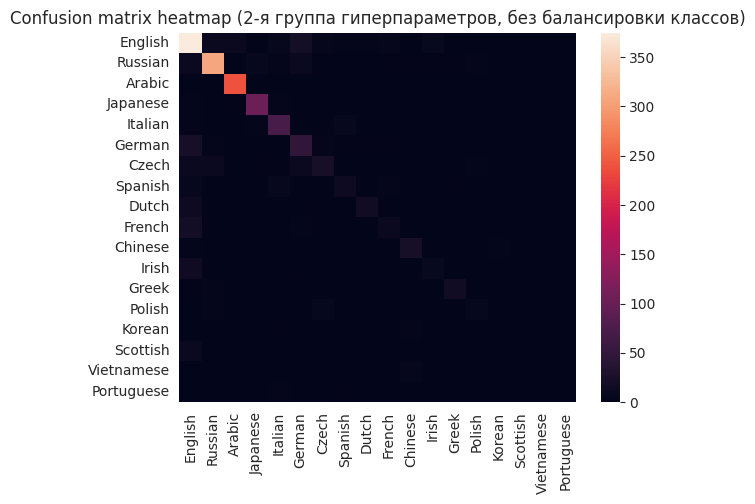

In [ ]:
sns.heatmap(cm, xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix heatmap (2-я группа гиперпараметров, без балансировки классов)')
plt.show()

In [ ]:
df.nationality.value_counts()

English       2972
Russian       2373
Arabic        1603
Japanese       775
Italian        600
German         576
Czech          414
Spanish        258
Dutch          236
French         229
Chinese        220
Irish          183
Greek          156
Polish         120
Korean          77
Scottish        75
Vietnamese      58
Portuguese      55
Name: nationality, dtype: int64

In [ ]:
# вычисляем recall для каждого класса

recall = recall_score(y_test, y_pred, average=None, labels=labels)
label_rec = dict(zip(labels, recall))

In [ ]:
sorted(label_rec.items(), key=lambda x: x[1])

[('Scottish', 0.0),
 ('Vietnamese', 0.0),
 ('Portuguese', 0.0),
 ('Korean', 0.18181818181818182),
 ('French', 0.2647058823529412),
 ('Irish', 0.2962962962962963),
 ('Polish', 0.3333333333333333),
 ('Spanish', 0.34210526315789475),
 ('Czech', 0.3548387096774194),
 ('Dutch', 0.4857142857142857),
 ('German', 0.5581395348837209),
 ('Chinese', 0.696969696969697),
 ('Greek', 0.7391304347826086),
 ('Italian', 0.7888888888888889),
 ('English', 0.8426966292134831),
 ('Russian', 0.8676056338028169),
 ('Japanese', 0.896551724137931),
 ('Arabic', 1.0)]

In [ ]:
# вычисляем precision для каждого класса

precision = precision_score(y_test, y_pred, average=None, labels=labels, zero_division=0)
label_prec = dict(zip(labels, precision))

In [ ]:
sorted(label_prec.items(), key=lambda x: x[1])

[('Scottish', 0.0),
 ('Vietnamese', 0.0),
 ('Portuguese', 0.0),
 ('Korean', 0.3333333333333333),
 ('French', 0.375),
 ('Irish', 0.42105263157894735),
 ('Polish', 0.46153846153846156),
 ('Czech', 0.46808510638297873),
 ('German', 0.5),
 ('Spanish', 0.5),
 ('Chinese', 0.6571428571428571),
 ('Dutch', 0.7083333333333334),
 ('Italian', 0.71),
 ('English', 0.7530120481927711),
 ('Greek', 0.7727272727272727),
 ('Japanese', 0.832),
 ('Russian', 0.8953488372093024),
 ('Arabic', 0.933852140077821)]

Обе модели больше всего путаются в определении фамилий, принадлежащих миноритарным классам (Шотландские, Вьетнамские, Португальские фамилии и т.д.). При этом модель без балансировки классов совсем не способна определить фамилии перечисленных национальностей. Балансировка помогает немного исправить ситуацию, жертвуя при этом качеством предсказания для мажоритарных классов, которые, тем не менее, всё равно предсказываются достаточно хорошо (это Арабские, Русские, Японские фамилии и т.д.). Хотя качество предсказания Английских фамилий при балансировке падает (возможно, в силу того, что это самый часто встречаемый класс в датасете).

Такое поведение модели связано с недостаточной репрезентативностью и/или малым количеством представителей большинства классов. Хотя есть и исключения. Например, греческие фамилии (в датасете их всего 156, а precision и recall ~75%). Возможно, это связано разнообразием фамилий в датасете или отличительными особенностями их формирования у тех или иных национальностей, которые ухватывает модель.